## Import libraries and setup folders

In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import pickle
import itertools
import py3Dmol
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from Bio.PDB import PDBIO, PDBParser
from metfish.utils import get_rmsd, align_structures

In [2]:
# set paths for different experimental and alphafold output files
working_dir = '//pscratch//sd//s//smprince//projects//metfish//data'
output_dir = f'{working_dir}//output//no_manipulation//240213'
experimental_dir = f'{working_dir}//pdbs'

# load pair dataframe
pair_df = pd.read_csv(f'{working_dir}//apo_holo_pairs_with_similarity.csv')

## Effects of structure recycling input
Two types of alphafold inference runs were performed. In one, alphafold was run on sequences that have multiple known experimental conformations (apo and holo) with no modification. In the other, the structural representation alphafold output (atom positions) was replaced during the recycling process with the known experimental values from pdb structure files.

### Data setup

In [3]:
# define data collating function
def create_manipulation_df(conformers, pairs, experimental_dir, af_output_dir, manipulation='none'):
    conf_data = []
    for conf in conformers:
        # add 'pair_id' value to all conformer pairs
        pair_id = [ind for ind, p in enumerate(pairs) if conf in p][0]  
        
        # get opposite conformer (set difference)
        alt_conf = [(set(p) - {conf}).pop() for p in pairs if conf in p][0]            
        
        # get the pdb/experimental data structure filename 
        exp_same_conformer = f'{experimental_dir}//{conf}_atom_only.pdb'                
        exp_alt_conformer = f'{experimental_dir}//{alt_conf}_atom_only.pdb'
        
        # find filenames of the first model over all recycling iterations
        if any(glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')):            
            af_fnames = glob.glob(f'{af_output_dir}//{conf}*rank_001*.r[0-9].pdb')
        else:
            af_fnames = glob.glob(f'{af_output_dir}//{alt_conf}*rank_001*.r[0-9].pdb')  
        
        # get recycling iteration values
        recycling_iter = [int(f.split('.pdb')[0][-1]) for f in af_fnames]              
        
        # calculate rmsd between recycling iteration and experimental data
        rmsd_same = [get_rmsd(exp_same_conformer, af) for af in af_fnames]             
        rmsd_alt = [get_rmsd(exp_alt_conformer, af) for af in af_fnames]
        
        conf_data.append(pd.DataFrame(dict(name=conf, 
                                           recycling_iteration=recycling_iter, 
                                           rmsd_same=rmsd_same,
                                           rmsd_alt=rmsd_alt,
                                           alt_conf=alt_conf,
                                           pair_id=pair_id,
                                           manipulation=manipulation,
                                           af_fname=af_fnames, 
                                           exp_same_fname=exp_same_conformer, 
                                           exp_alt_fname=exp_alt_conformer,)))
    return conf_data

In [4]:
# create conformer dataframes
output_dir_with_manipulation = f'{working_dir}//output//replace_conformer//240213'

pairs = list(zip(pair_df['apo_id'], pair_df['holo_id']))
conformers = [conf for p in pairs for conf in p]
less_similar_conformer = pair_df['less_similar_conformer'].to_list()
df_no_maniplation = create_manipulation_df(conformers, 
                                           pairs, 
                                           experimental_dir, 
                                           output_dir,
                                           manipulation='none')
df_with_manipulation = create_manipulation_df(conformers, 
                                              pairs, 
                                              experimental_dir, 
                                              output_dir_with_manipulation, 
                                              manipulation='template')

conf_df = pd.concat([*df_no_maniplation, *df_with_manipulation])
conf_df = conf_df.sort_values(['pair_id', 'name','manipulation', 'recycling_iteration'])
conf_df.head()

name  recycling_iteration  rmsd_same   rmsd_alt alt_conf  pair_id  \
5  4LP5_A                    0   8.930768  10.996714   4P2Y_A        0   
0  4LP5_A                    1   9.031797  10.002702   4P2Y_A        0   
4  4LP5_A                    2   8.558395   9.969888   4P2Y_A        0   
3  4LP5_A                    3   8.508500   9.605280   4P2Y_A        0   
2  4LP5_A                    4   8.313478   9.235455   4P2Y_A        0   

  manipulation                                           af_fname  \
5         none  //pscratch//sd//s//smprince//projects//metfish...   
0         none  //pscratch//sd//s//smprince//projects//metfish...   
4         none  //pscratch//sd//s//smprince//projects//metfish...   
3         none  //pscratch//sd//s//smprince//projects//metfish...   
2         none  //pscratch//sd//s//smprince//projects//metfish...   

                                      exp_same_fname  \
5  //pscratch//sd//s//smprince//projects//metfish...   
0  //pscratch//sd//s//smprince//projects//metfish...   
4  //pscratch//sd//s//smprince//projects//metfish...   
3  //pscratch//sd//s//smprince//projects//metfish...   
2  //pscratch//sd//s//smprince//projects//metfish...   

                                       exp_alt_fname  
5  //pscratch//sd//s//smprince//projects//metfish...  
0  //pscratch//sd//s//smprince//projects//metfish...  
4  //pscratch//sd//s//smprince//projects//metfish...  
3  //pscratch//sd//s//smprince//projects//metfish...  
2  //pscratch//sd//s//smprince//projects//metfish...

### Visualization

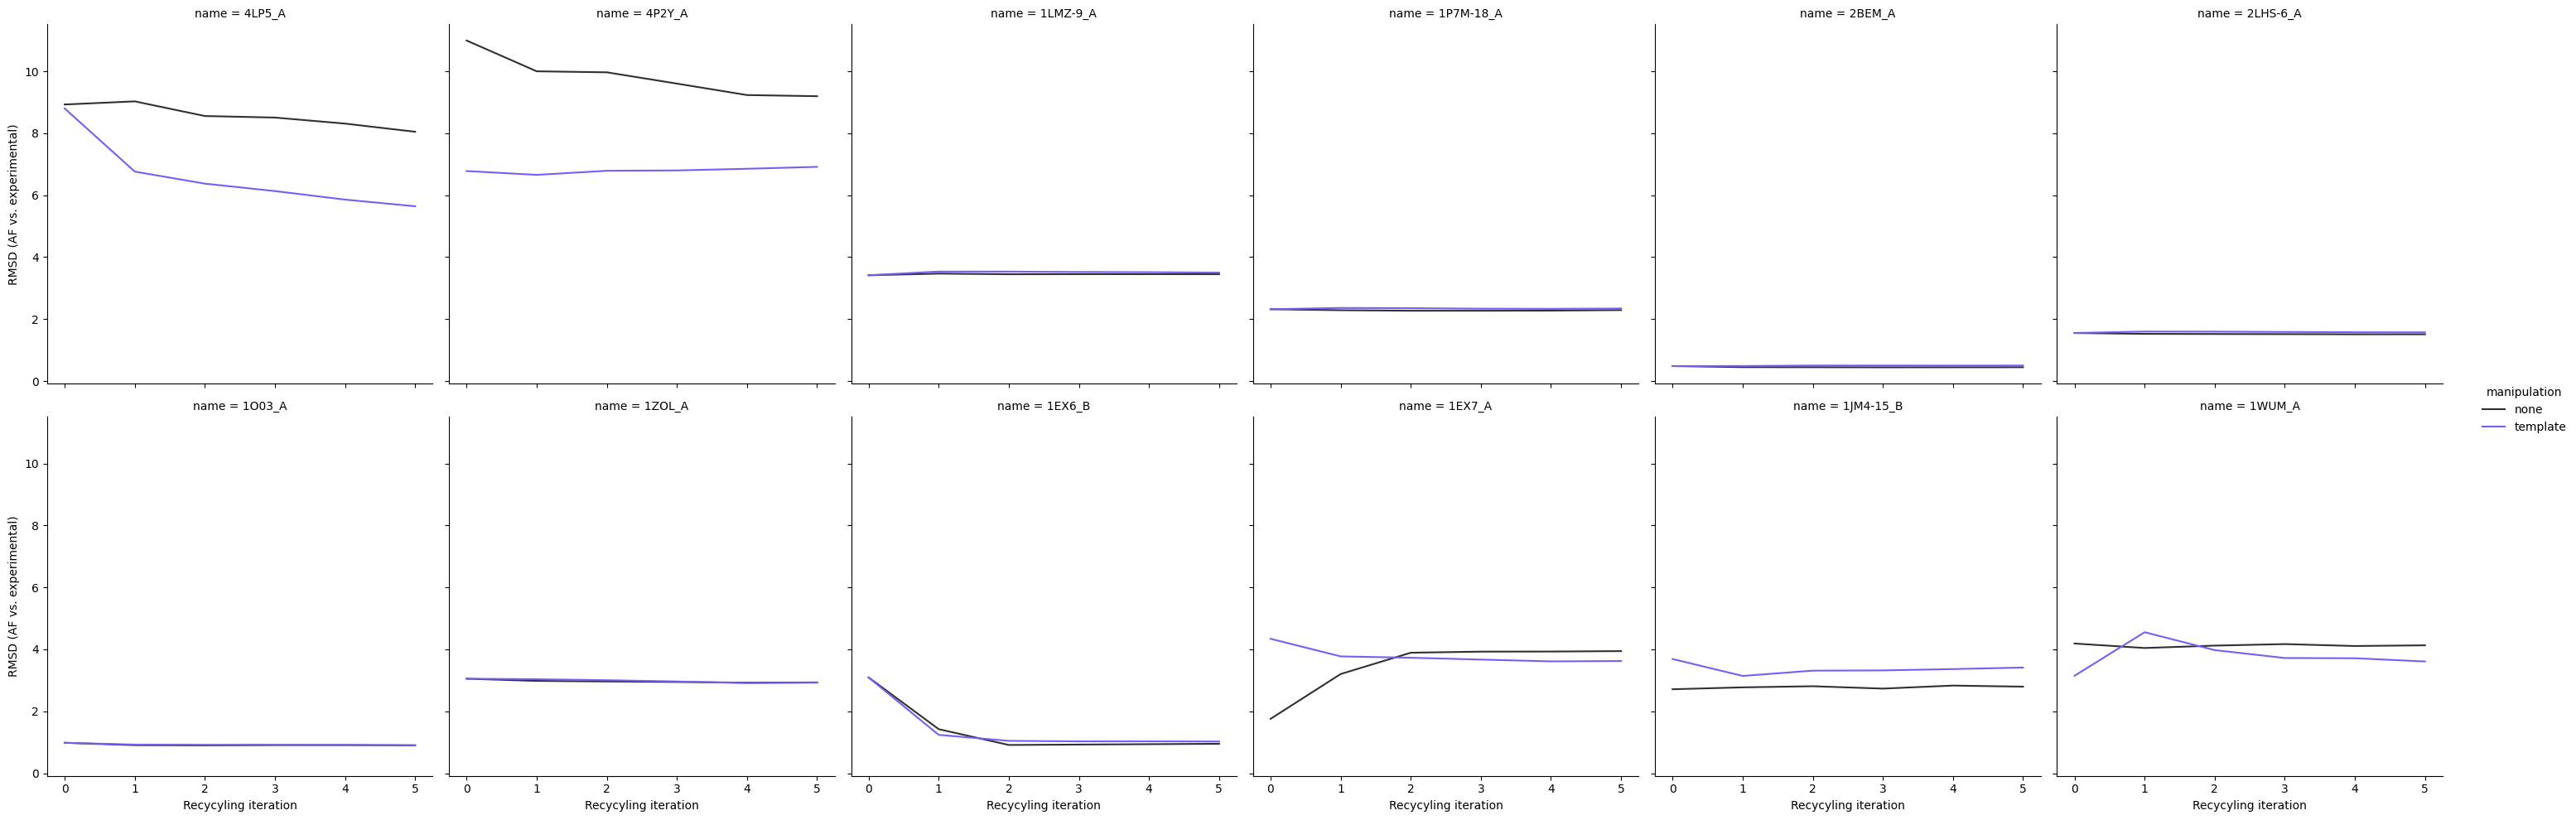

In [5]:
# plot structure similarity across recycling iterations
g = sns.relplot(data=conf_df, 
                x='recycling_iteration',
                y='rmsd_same', 
                col='name', 
                hue='manipulation', 
                col_wrap=6, 
                kind='line', 
                palette=['#303030', '#785cf7'])

(g.set_axis_labels("Recycyling iteration", "RMSD (AF vs. experimental)")
  .tight_layout())

**Structure similarity across recycling iterations**

Each subplot is a single conformation.
y-axis indicates RMSD between the AF output vs. experimental structure (lower values = more similar).
x-axis indicates recycling iterations (0 is after one pass through AF network, 5 is end).
Black lines indicate the AF prediction without any manipulation .
(i.e. same sequence/output for each conformer pair, just two different similarity scores over time).
Purple lines indicate the AF prediction when the experimental structure for that conformer was injected at each recycling iteration.
(i.e. trying to drive alphafold prediction to be more similar to that conformer).

[Text(0.5, 0, 'RMSD AF vs. apo'), Text(0, 0.5, 'RMSD AF vs. holo')]

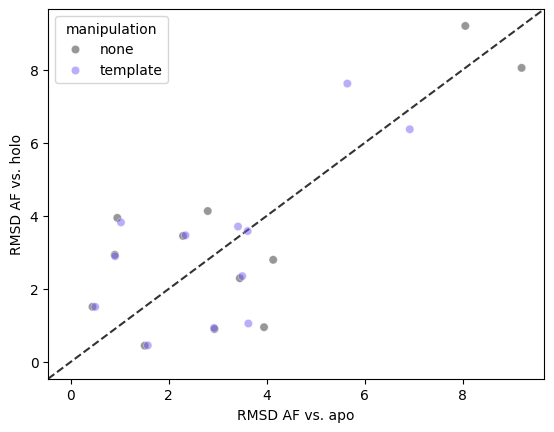

In [6]:
# plot structural similarity of apo vs. holo conformers
g = sns.scatterplot(data=conf_df.query(f'recycling_iteration == 5 '), 
                x='rmsd_same',
                y='rmsd_alt', 
                hue='manipulation',
                alpha=0.5,
                palette=['#303030', '#785cf7'])
g.axline((0, 0), slope=1, c=".2", ls="--", zorder=0)
g.set(xlabel='RMSD AF vs. apo', ylabel='RMSD AF vs. holo')

In [24]:
# make structure visualization function
def plot_recycling_iteration(df_row, colnames, exp_colname, colors=('blue','purple')):
    for i, c in enumerate(colnames):
        view.addModel(open(df_row[exp_colname], "r").read(), "pdb", viewer=(i, df_row['recycling_iteration']))
        view.addModel(open(df_row[c], "r").read(), "pdb", viewer=(i, df_row['recycling_iteration']))
    
        view.setStyle({'model':0}, {'cartoon':{'color':'white'}}, viewer=(i, df_row['recycling_iteration']))
        view.setStyle({'model':1}, {'cartoon':{'color':colors[i]}}, viewer=(i, df_row['recycling_iteration']))

# visualize structural representations across recycling iterations 
pdb_name = "1EX7_A"
manipulations = ('none', 'template')
exp_colname = 'exp_same_fname'

example_df = (conf_df
              .query(f"name == '{pdb_name}'")
              .pivot(columns='manipulation', values='af_fname', index=['name', exp_colname, 'recycling_iteration'])
              .reset_index()
              .sort_values('recycling_iteration'))

aligned_colnames = [f'{m}_aligned' for m in manipulations]
for m in manipulations:
    example_df[f'{m}_aligned'] = example_df.apply(lambda x: align_structures(x[exp_colname], x[m]), axis=1)
    
view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js", viewergrid=(2, 6))
example_df.apply(lambda x: plot_recycling_iteration(x, aligned_colnames, exp_colname), axis=1)
view.zoomTo()
view.show()
view.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

**3D structural representations across recycling iterations**

Each column indicates a recycling iteration (left = start of AF run, right = end)
Top row is the AF structural output without any manipulations (blue = AF prediction, white = experimental structure)
Bottom row is the AF structural output with manipulations (purple = AF prediction, white = experimental structure)

## Correlation between intermediate pair representations and structural outputs

### Data setup

In [8]:
# calc distance between pair representations
def get_euclidean_distance(pair1, pair2):
    with open(pair1, 'rb') as file:
            pair1_data = pickle.load(file)
    with open(pair2, 'rb') as file:
        pair2_data = pickle.load(file)

    # calculate distance between pair representations 
    # note - have to divide and remultiply max bc float16 too small, still some overflow warnings
    diff_a_b = pair1_data['representations']['pair'] - pair2_data['representations']['pair']
    a_b_max = np.max(diff_a_b) 
    norm = np.linalg.norm(diff_a_b / a_b_max) * a_b_max  
    distance = norm / np.sqrt(np.size(pair1_data['representations']['pair']))
    
    return distance

In [9]:
# determine pair combinations (diff between models, diff between recycling iterations)
# note - samples are not really independent
combos = list(itertools.combinations(range(1,6), 2))
combos = list(itertools.combinations(combos,2))

# for each sequence, calculate metrics
corr_data = []
for seq in pair_df['apo_id'].to_list():
    print(f'Calculating distances for {seq}...')
    for c1, c2 in combos:
        # load intermediate pair representations and structure representations
        struct1 = glob.glob(f'{output_dir}//{seq}*rank_00{c1[0]}*.r{c1[1]}.pdb')[0]
        struct2 = glob.glob(f'{output_dir}//{seq}*rank_00{c2[0]}*.r{c2[1]}.pdb')[0]
        
        pair1 = glob.glob(f'{output_dir}//{seq}*rank_00{c1[0]}*.r{c1[1]}.pickle')[0]
        pair2 = glob.glob(f'{output_dir}//{seq}*rank_00{c2[0]}*.r{c2[1]}.pickle')[0]
        
        # calculate RMSD between structures
        rmsd = get_rmsd(struct1, struct2)
        
        # load intermediate pair representations
        distance = get_euclidean_distance(pair1, pair2)
        
        corr_data.append((dict(sequence_name=seq, 
                               val1_model=c1[0], 
                               val2_model=c2[0], 
                               val1_recycling=c1[1], 
                               val2_recycling=c2[1], 
                               rmsd=rmsd, 
                               distance=distance)))
        
corr_df = pd.DataFrame(corr_data)
corr_df.drop(corr_df.loc[corr_df['distance']== np.inf].index, inplace=True)
corr_df.head()

Calculating distances for 4LP5_A...
Calculating distances for 1LMZ-9_A...
Calculating distances for 2LHS-6_A...
Calculating distances for 1ZOL_A...
Calculating distances for 1EX6_B...
Calculating distances for 1JM4-15_B...


sequence_name  val1_model  val2_model  val1_recycling  val2_recycling  \
0        4LP5_A           1           1               2               3   
1        4LP5_A           1           1               2               4   
2        4LP5_A           1           1               2               5   
3        4LP5_A           1           2               2               3   
4        4LP5_A           1           2               2               4   

       rmsd  distance  
0  0.550607  1.180469  
1  1.132961  1.368404  
2  1.448740  1.523451  
3  7.615072  4.338958  
4  7.567838  4.374195

### Visualization

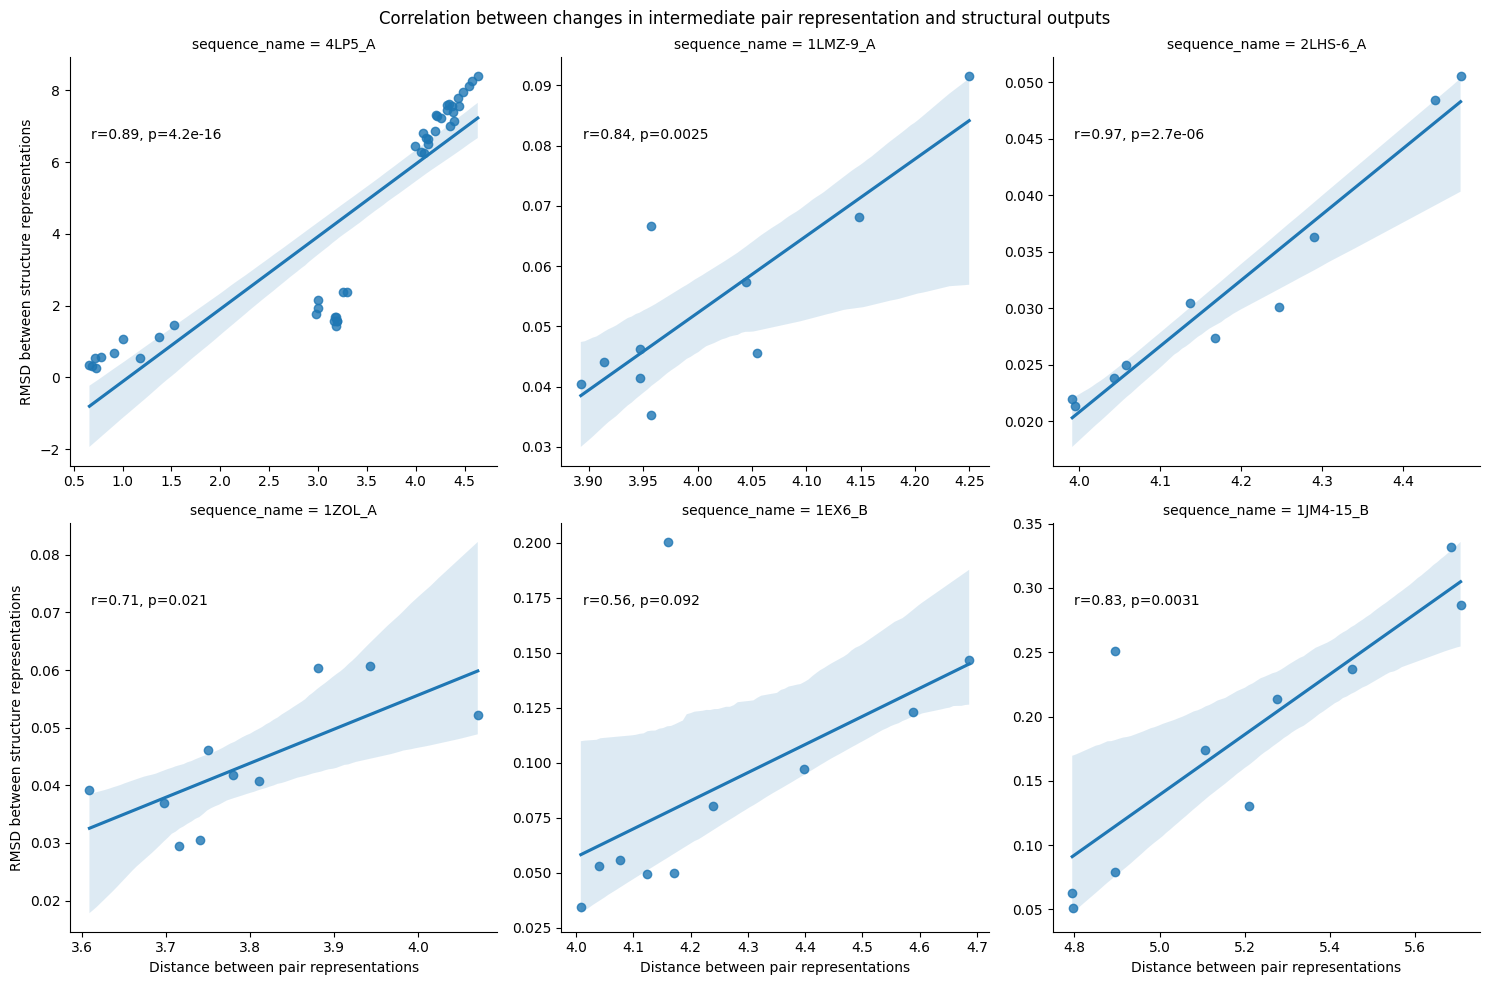

In [10]:
def annotate_with_r(data, **kws):
    r, p = pearsonr(data['distance'], data['rmsd'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

g = sns.lmplot(data=corr_df,
               x="distance", 
               y="rmsd", 
               col="sequence_name",
               col_wrap=3,
               facet_kws={'sharey': False, 'sharex': False}
)
g.fig.suptitle('Correlation between changes in intermediate pair representation and structural outputs')
g.set_xlabels('Distance between pair representations')
g.set_ylabels('RMSD between structure representations')
g.map_dataframe(annotate_with_r)
g.fig.tight_layout()

**Correlation between AlphaFold intermediate pair and structure representations**

Changes in the intermediate pair representations are positively correlated with structural output differences (when comparing between different models and recycling iterations of a single input sequence)